***
# Solution: BERT Fine-Tuning (pure)
***




*By Asmik Nalmpatian and Lisa Wimmer – for Intro to NLP*

*Methodology based on: https://arxiv.org/pdf/1810.04805.pdf*

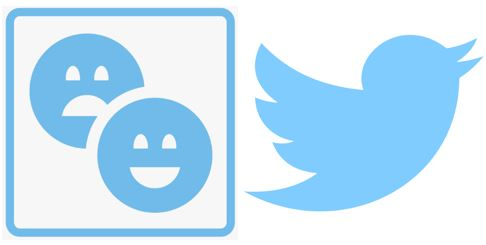

This notebook is supposed to give an overview over the used functionalities. We will show how to use BERT - Bidirectional Encoder Representations from Transformers - with PyTorch library (huggingface) to fine-tune a pretrained model in tweet classification. 

The following pretrained BERT models can be used and are available in transformers huggingface: 

*   *bert-base-german-cased*
*   *bert-base-german-dbmdz-cased*
*   *bert-base-german-dbmdz-uncased*
*   *distilbert-base-german-cased*

After using these models to extract (hopefully) high quality features from our text data, we aim to fine-tune them on our specific task using a manually labeled sample of German tweets to gain state of the art predictions.

All in all the tweets will be classified into *positive* and *negative* classes using a pretrained BERT model. We will take it, add an untrained layer of neurons on the end and train a new model specifically for the classification task. 


Advantages of fine-tuning:  

*   Fast, because we already have pretrained layers of the network (only 2-4 epochs after adding 1 fully connected layer on top are enough to train as the authors recommend)
*   Less data is sometimes enough to achieve good performance
*   Usually preferable results: because of task-specific adjustments of the weights





## Prepare GPU

1. Check: Edit --> Notebook settings -> Hardware accelerator -> *GPU* 


2. You will need access to the following files: *data_germeval_2017.tsv*, *data_labeled_processed.csv*


## Data

1. On the left command pane, move to the `Files` section.
2. Select 'Upload to the session storage'.
3. Upload the `data_germeval_2017.tsv` and `data_labeled_processed.csv` data from the course website (the data will vanish as soon as you terminate the colab session).

In [1]:
# Where are you now?
import os, sys
print("My current working directory is in folder: ", os.getcwd(), ".")

My current working directory is in folder:  /content .


## Google Colab GPU Connection

Otherwise training a large NN may take a very long time. 

In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
# Identify and specify the GPU as the device
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Fine-Tuning 

Install Huggingface Library / transformers package and specify the pretrained transformer model. (Uncased means that the texts have only lowercase letters)


### Exercise 1
*Try another pretrained model available in transformers library.*

In [ ]:
!pip install transformers
from transformers import BertTokenizer

pretrained_model = "bert-base-german-cased"                                           # SOLUTION: i.e. "distilbert-base-german-cased"

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(pretrained_model) # Additionally do lower case for pretrained uncased models

### Exercise 2
*Pre-process the Twitter data set.*

Load and prepare the tweets and labels 

In [6]:
# Prepare path to the dataset contaning tweets
filename_tweets = "data_labeled_processed.csv"                                                    # SOLUTION

In [7]:
# Load the dataset into a pandas dataframe
import pandas as pd
df = pd.read_csv(filename_tweets, delimiter = ',', header = 0)                                    # SOLUTION 

In [8]:
# Look at the shape of the dataframe
df.shape                                                                                          # SOLUTION 

(498, 23)

In [9]:
# Look at the first rows of the dataframe
df.head()                                                                                         # SOLUTION

,doc_id,twitter_username,twitter_available,twitter_created_at,twitter_full_text_topic,twitter_full_text,twitter_retweet_count,twitter_favorite_count,twitter_followers_count,twitter_location,twitter_word_count,twitter_year,twitter_month,twitter_week,twitter_time_index_month,twitter_time_index_week,twitter_emojis,twitter_hashtags,twitter_tags,label,topic,from,to
0,ABaerbock15156546001,ABaerbock,True,2018-01-11T07:10:00Z,Habe mir das Gro Ko-Sondierungspapier zu Klima...,Habe mir das Gro Ko-Sondierungspapier zu Klima...,111,233,107693,Brandenburg,32,2018,1,2,5,17,NaN,#GroKo|#Klima|#Klimadiplomatie|#Merkel|#kohlea...,NaN,negative,Klimapolitik,239,251
1,ABaerbock15210084001,ABaerbock,True,2018-03-14T06:20:00Z,"Auch weltweit sieht man, dass Angela Merkel s ...","Auch weltweit sieht man, dass Angela Merkel s ...",24,96,107693,Brandenburg,27,2018,3,11,7,26,NaN,#Merkel|#GroKo,NaN,negative,Klimapolitik,203,215
2,ABaerbock15216341401,ABaerbock,True,2018-03-21T12:09:00Z,"Der groessten globalen Herausforderung, der Kl...","Der groessten globalen Herausforderung, der Kl...",39,153,107693,Brandenburg,38,2018,3,12,7,27,NaN,#Klimakrise|#Regierungserklaerung|#Koalitionsv...,NaN,negative,Klimapolitik,284,296
3,ABaerbock15252349801,ABaerbock,True,2018-05-02T04:23:00Z,Wir brauchen eine andere Verkehrspolitik - weg...,Wir brauchen eine andere Verkehrspolitik - weg...,49,213,94139,Brandenburg,38,2018,5,18,9,33,NaN,NaN,NaN,negative,Verkehrspolitik,25,40
4,ABaerbock15256297201,ABaerbock,True,2018-05-06T18:02:00Z,Das ist die Leistung von Hunderten Wahlkaempfe...,Das ist die Leistung von Hunderten Wahlkaempfe...,39,301,107693,Brandenburg,40,2018,5,19,9,34,NaN,#kwsh|#kow18|#Kommunalwahl,NaN,positive,Kommunalpolitik,251,266


In [10]:
# Convert labels to numeric: 1 for "positive", 0 for "negative" and call the column "label_binary"
df['label_binary'] = [1 if label == "positive" else 0 for label in df.label]                      # SOLUTION

In [11]:
# Drop NA values in the column "label"
df = df.dropna(subset=['label'])

In [12]:
# Get the lists of tweets and their labels.
tweets = df.twitter_full_text.values
labels = df.label_binary.values

In [13]:
# Print the second tweet in the dataframe (Take care of right indexing!)
tweets[1]

'Auch weltweit sieht man, dass Angela Merkel s Gro Ko 3.0 nicht klimatauglich ist, sondern vielmehr das Pariser Abkommen unterlaeuft. Auch aussenpolitisch fatal. Daher Klimasofortprogramm jetzt auflegen!'

In [14]:
# Is the sentiment expressed in this tweet negative or positive? Check by printing the label.
labels[1]                                                                                         # SOLUTION

0

In [15]:
# Count the occurrences of positive and negative tweets
import numpy as np
np.count_nonzero(labels == 1)                                                                     # SOLUTION

106

GermEval Data Preparation

In [16]:
# Prepare path to the dataset containg GermEval texts
filename_germeval = "data_labeled_processed.csv"

In [17]:
# Load the dataset into a pandas dataframe
import pandas as pd
germeval = pd.read_csv(filename_germeval, 
                   sep='\t',
                   header=None, 
                   names = ["full_text", "0", "label", "2"])

In [18]:
# Further preprocessing
germeval['label_binary'] = [1 if label == 'positive' else 0 for label in germeval.label]
germeval = germeval.loc[lambda x: x['label'] != "neutral"]

In [19]:
# Get the lists of tweets and their labels -> Use only the first 99 rows
tweets_germeval = germeval.full_text.values[0:99]
labels_germeval = germeval.label_binary.values[0:99]

First, we need to tokenize our text to be able to feed it into the BERT model. 

Below an example of tokenized and raw tweet versions is shown. To tokenize the text we have to specify and use the pretrained BERT because each model has a fixed vocabulary (containing tokens, so wordpieces) and the BERT tokenizer handles words which are not in the certain vocabulary in a specific way.

Each token is then mapped to its index in the tokenizer vocabulary.

In [20]:
# Print the raw tweet.
print('Raw: ', tweets[0])

# Print the tweet split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))

# Print the tweet mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

Raw:  Habe mir das Gro Ko-Sondierungspapier zu Klima nochmal genau angeschaut. Krass: De facto wird sogar das Kyoto-Protokoll, der Meilenstein der Klimadiplomatie fuer nichtig erklaert! Frau Merkel, das geht so nicht! Nachbessern! kohleausstieg
Tokenized:  ['Hab', '##e', 'mir', 'das', 'Gro', 'Ko', '-', 'Son', '##die', '##rung', '##sp', '##ap', '##ier', 'zu', 'Klima', 'noch', '##mal', 'genau', 'angesch', '##aut', '.', 'Kras', '##s', ':', 'De', 'fa', '##ct', '##o', 'wird', 'sogar', 'das', 'Ky', '##oto', '-', 'Protokoll', ',', 'der', 'Meilen', '##stein', 'der', 'Klima', '##di', '##plomat', '##ie', 'f', '##uer', 'nichtig', 'erk', '##la', '##ert', '!', 'Frau', 'Merkel', ',', 'das', 'geht', 'so', 'nicht', '!', 'Nach', '##besser', '##n', '!', 'ko', '##hle', '##auss', '##ti', '##eg']
Token IDs:  [9689, 26897, 3667, 93, 951, 673, 26935, 1343, 2930, 23620, 168, 425, 97, 81, 6914, 357, 446, 2971, 16745, 956, 26914, 26237, 26902, 26964, 576, 20568, 1920, 26910, 292, 2215, 93, 13235, 9857, 26935, 1

In the next step we add special tokens to the start *CLS* and end of each tweet *SEP*.

In [21]:
# Tokenize all of the tweets and map the tokens to their word IDs.
input_ids = []

# For every tweet...
for tweet in tweets:
    encoded_tweet = tokenizer.encode(
                        tweet, # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded tweet to the list.
    input_ids.append(encoded_tweet)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])



Original:  Habe mir das Gro Ko-Sondierungspapier zu Klima nochmal genau angeschaut. Krass: De facto wird sogar das Kyoto-Protokoll, der Meilenstein der Klimadiplomatie fuer nichtig erklaert! Frau Merkel, das geht so nicht! Nachbessern! kohleausstieg
Token IDs: [3, 9689, 26897, 3667, 93, 951, 673, 26935, 1343, 2930, 23620, 168, 425, 97, 81, 6914, 357, 446, 2971, 16745, 956, 26914, 26237, 26902, 26964, 576, 20568, 1920, 26910, 292, 2215, 93, 13235, 9857, 26935, 10252, 26918, 21, 17930, 1407, 21, 6914, 3748, 13461, 12, 69, 667, 20719, 895, 129, 335, 26982, 946, 5654, 26918, 93, 1398, 181, 149, 26982, 326, 4379, 26898, 26982, 7424, 2039, 10685, 15099, 640, 4]


In [22]:
# Do the same for GermEval 
input_ids_germeval = []

# For every tweet...
for tweet_germeval in tweets_germeval:
    encoded_tweet = tokenizer.encode(
                        tweet_germeval,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded tweet to the list.
    input_ids_germeval.append(encoded_tweet)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets_germeval[0])
print('Token IDs:', input_ids_germeval[0])

Original:  doc_id,twitter_username,twitter_available,twitter_created_at,twitter_full_text_topic,twitter_full_text,twitter_retweet_count,twitter_favorite_count,twitter_followers_count,twitter_location,twitter_word_count,twitter_year,twitter_month,twitter_week,twitter_time_index_month,twitter_time_index_week,twitter_emojis,twitter_hashtags,twitter_tags,label,topic,from,to
Token IDs: [3, 13463, 26909, 26983, 46, 26904, 26918, 209, 9170, 26983, 11838, 212, 1431, 26918, 209, 9170, 26983, 18, 4973, 9758, 6180, 26918, 209, 9170, 26983, 1350, 26836, 25110, 26983, 5563, 26918, 209, 9170, 26983, 69, 2701, 26983, 25059, 26983, 21769, 434, 26918, 209, 9170, 26983, 69, 2701, 26983, 25059, 26918, 209, 9170, 26983, 19638, 384, 75, 26983, 1350, 1504, 4053, 26918, 209, 9170, 26983, 20568, 511, 1182, 26983, 1350, 1504, 4053, 26918, 209, 9170, 26983, 790, 9931, 355, 26983, 1350, 1504, 4053, 26918, 209, 9170, 26983, 9087, 2856, 15099, 23, 26918, 209, 9170, 26983, 5883, 26904, 26983, 1350, 1504, 4053, 2691

Then we pad and truncate all tweets to a constant fixed length 

In [23]:
print('Max sentence length: ', max([len(tweet) for tweet in input_ids]))

Max sentence length:  84


In [24]:
print('Max sentence length for GermEval data: ', max([len(tweet_germeval) for tweet_germeval in input_ids_germeval]))

Max sentence length for GermEval data:  267


In [25]:
from keras.preprocessing.sequence import pad_sequences


# Set the maximum sequence length.
# A bit larger than the maximum training tweet length of 91/110... (with germeval 3202/3300 -> bert has a max length limit of tokens = 512, we cut the longer texts off and only use the first 512 Tokens)
MAX_LEN = 250

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" - pad and truncate at the end of the sequence, as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

# Pad our input tokens with value 0 for Germeval data 
input_ids_germeval = pad_sequences(input_ids_germeval, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 250 values...

Padding token: "[PAD]", ID: 0

Done.


Create attention masks which indicates which tokens are words and which are padding (if token ID is 0 then it is padding and the attention mask is set to 0)

In [26]:
# Create attention masks
attention_masks = []

# For each sentence...
for tweet in input_ids:
    
    att_mask = [int(token_id > 0) for token_id in tweet]
    
    # Store the attention mask for each tweet.
    attention_masks.append(att_mask)

In [27]:
# Create attention masks for Germeval data 
attention_masks_germeval = []

# For each sentence...
for tweet_germeval in input_ids_germeval:
    
    att_mask = [int(token_id > 0) for token_id in tweet_germeval]
    
    # Store the attention mask for each tweet.
    attention_masks_germeval.append(att_mask)

Now, we use train_test_split to split our data into train, test sets first  and then split the initial train set further into a final train set and validation set for training


### Exercise 3
*Split into train and test sets.*

In [28]:
# Without-GermEval-case
from sklearn.model_selection import train_test_split
import numpy as np

# Use 80% for training and 20% for validation.
train_inputs2, test_inputs, train_labels2, test_labels = train_test_split(input_ids, labels, 
                                                            random_state = 2021, test_size = 0.2, stratify = labels)       # SOLUTION

# Do the same for the masks.
train_masks2, test_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state = 2021, test_size = 0.2, stratify = labels)                      # SOLUTION


# Use 20% of train set as validation set 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs2, train_labels2, 
                                                                                    test_size = 0.2, random_state = 2021)  # SOLUTION

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(train_masks2, train_labels2,                                        # SOLUTION
                                             random_state=2020, test_size=0.2)    

In [29]:
# How many training tweets do you have? 
len(train_inputs)

318

In [30]:
# How many test tweets do you have? 
len(test_inputs)

100

### Exercise 4
*Additionally use GermEval data set for training.*

In [31]:
# Use additional Germeval data for training
from sklearn.model_selection import train_test_split
import numpy as np

# Use 80% for training and 20% for validation.
train_inputs1, test_inputs, train_labels1, test_labels = train_test_split(input_ids, labels,                                # SOLUTION
                                                            random_state=42, test_size=0.2, stratify = labels)

# Do the same for the masks.
train_masks1, test_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2, stratify = labels)

# Mix train_inputs1, train_labels1, train_masks1 with germeval data
train_inputs2 = np.concatenate((train_inputs1, input_ids_germeval), axis=0)
train_labels2 = np.concatenate((train_labels1, labels_germeval), axis=None)
train_masks2  = np.concatenate((train_masks1, attention_masks_germeval), axis=0)



# Use 20% of train set as validation set 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs2, train_labels2,           # SOLUTION
                                                                                    test_size=0.2, random_state=2020) 

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(train_masks2, train_labels2,                                         # SOLUTION
                                             random_state=2020, test_size=0.2)    

Convert all inputs and labels into torch tensors, the required datatype 
for our model.

In [32]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

### Exercise 5
*Try another set of hyperparameters recommended by BERT authors.*

In [33]:
# Define batch size here to let DataLoader know. 
# BERT-authors recommend a batch size of 16 or 32 for fine-tuning.
batch_size = 32

In [34]:
# Define the learning rate 
learning_rate = 5e-5

In [35]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 2 

The torch DataLoader class enables to create  an iterator for our data in order to save memory during training process.

In [36]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


Load BertForSequenceClassification, the pretrained BERT model with a single 
linear classification layer on top. This is the one for classification tasks in general. *(see for more details https://huggingface.co/transformers/v2.2.0/model_doc/bert.html)*

In [37]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    pretrained_model, 
    num_labels = 2, # The number of output labels--2 for binary classification. Can be increased for multiclass
    output_attentions = False, 
    output_hidden_states = False 
)

# Run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [38]:
# All of the model's parameters as a list of tuples.
params = list(model.named_parameters())

Get the optimizer after loading the model. 

*(see for more details on AdamW Optimizer https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109)*

In [39]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )

In [40]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [41]:
# helper function for calculating accuracy
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [42]:
# helper function for formatting elapsed times
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Exercise 6
*Fine-tune your model.*

Let's start the actual training process

In [43]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 55

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

# For each epoch:
for epoch_i in range(0, epochs):
    
    ## TRAIN
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # how long does the training epoch take.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Turn on the training mode for the model. 
    model.train()

    # For each batch of training data:
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack the batch and load onto the GPU.
        # Each batch contains input ids, attention masks, labels. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Remove any previously calculated gradients before performing a
        # backward pass. 
        model.zero_grad()        

        # Do a forward pass. 
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 
        total_loss += loss.item()

        # Do a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step.
        optimizer.step()

        scheduler.step()

    # Avg loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Need for plotting the learning curve later.
    loss_values.append(avg_train_loss)

    print("")
    print("  Avg training loss: {0:.2f}".format(avg_train_loss))
    print("  Epoch time: {:}".format(format_time(time.time() - t0)))
        
    ## VALIDATE
    # After each training epoch, we measure performance on
    # validation set.

    t0 = time.time()

    # Turn on the evaluation mode of the model.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get logit values predicted for each class.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Accuracy for this batch of validation tweets.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation time: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...

  Avg training loss: 0.40
  Epoch time: 0:00:17
  Accuracy: 0.88
  Validation time: 0:00:02

======== Epoch 2 / 2 ========
Training...

  Avg training loss: 0.19
  Epoch time: 0:00:17
  Accuracy: 0.93
  Validation time: 0:00:02

Training complete!


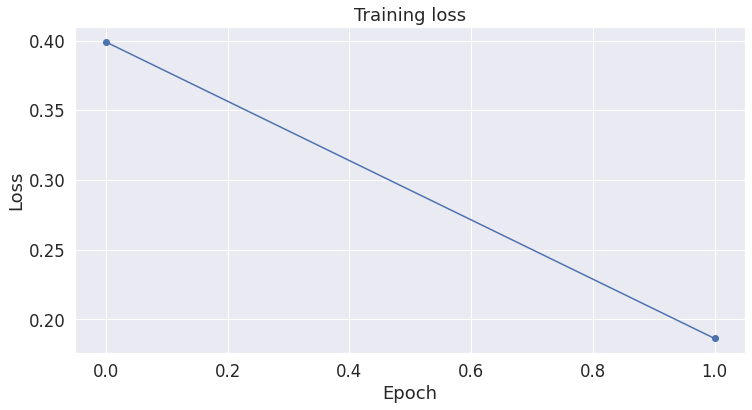

In [44]:
# Visualize the training results
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Evaluation on Test Set

In [45]:
# Prediction on test set

print('Predicting labels for {:,} test tweets...'.format(len(test_inputs)))

# Turn on the evaluation mode of the model
model.eval()

predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Compute gradients, save memory and speed up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 100 test tweets...
    DONE.


In [46]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label_binary.sum(), len(df.label_binary), (df.label_binary.sum() / len(df.label_binary) * 100.0)))

Positive samples: 106 of 498 (21.29%)


Performance measures

In [47]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]

In [48]:
# List of keys of the highest scores, i.e. predictions (indices of the maximum values along an axis)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [49]:
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

F1 score, accuracy and confusion matrix

### Exercise 7
*Print out the accuracy score.*

In [50]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# F1-Score (weighted)
f1_value = f1_score(flat_predictions, flat_true_labels, average="weighted")

# Accuracy Score
accuracy = accuracy_score(flat_predictions, flat_true_labels)                         # SOLUTION

print("F1 Score (Weighted): {}".format(f1_value))
print("Accuracy: {}".format(accuracy))

F1 Score (Weighted): 0.8890712487038958
Accuracy: 0.89


In [51]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    cm = confusion_matrix(y_true=true_labels, 
                                  y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=[[0,0],[0,1]]), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=[[0,0],[0,1]])) 
    return cm_frame   

In [52]:
confusion_mat = display_confusion_matrix(true_labels = flat_true_labels, predicted_labels = flat_predictions)
confusion_mat

Predicted:    
                   1   0
Actual: 1         16   5
        0          6  73